✅ Normalized dataset is ready!
Found 13685 images belonging to 3 classes.
Found 3419 images belonging to 3 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 297s 679ms/step - accuracy: 0.4812 - loss: 1.1358 - val_accuracy: 0.6420 - val_loss: 0.7227
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 274s 641ms/step - accuracy: 0.6523 - loss: 0.7849 - val_accuracy: 0.6496 - val_loss: 0.7040
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 301s 703ms/step - accuracy: 0.7044 - loss: 0.6775 - val_accuracy: 0.6566 - val_loss: 0.6969
Epoch 4/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 272s 637ms/step - accuracy: 0.7241 - loss: 0.6378 - val_accuracy: 0.6622 - val_loss: 0.7166
Epoch 5/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 274s 640ms/step - accuracy: 0.7403 - loss: 0.5979 - val_accuracy: 0.6660 - val_loss: 0.7162


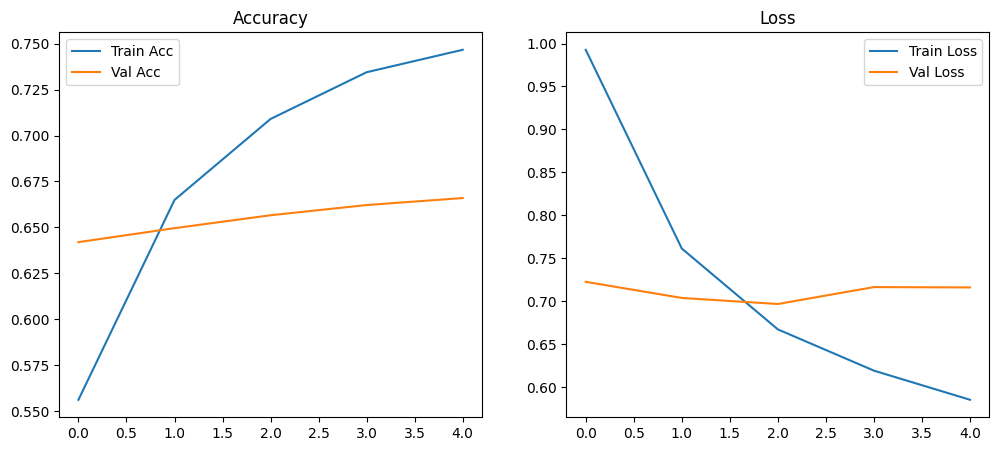

107/107 ━━━━━━━━━━━━━━━━━━━━ 59s 538ms/step
🔍 Classification Report:

              precision    recall  f1-score   support

   1NonCOVID       0.67      0.90      0.77      1378
      2COVID       0.68      0.50      0.57      1518
        3CAP       0.63      0.54      0.58       523

    accuracy                           0.67      3419
   macro avg       0.66      0.65      0.64      3419
weighted avg       0.67      0.67      0.65      3419



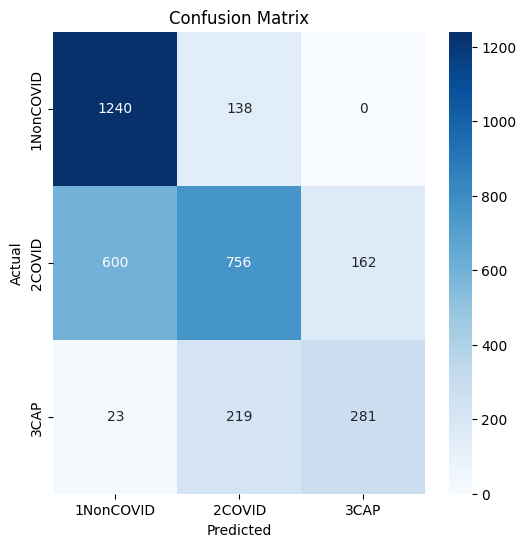

107/107 ━━━━━━━━━━━━━━━━━━━━ 54s 506ms/step - accuracy: 0.8131 - loss: 0.4583
✅ Final Accuracy: 0.6660
❌ Error Rate: 33.40%


In [1]:
# ✅ Unzip Normalized Dataset
import zipfile

with zipfile.ZipFile("normalized_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/normalized_dataset")

print("✅ Normalized dataset is ready!")

# 🧪 Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 📁 Dataset paths (use resized 160x160 images)
data_path = "/content/normalized_dataset/curated_data"
img_size = 160
batch_size = 32

# 🔄 Data generators with normalization
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# 🔧 MobileNetV2 model with smaller input and dropout
base_model = MobileNetV2(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
base_model.trainable = False  # freeze base to train faster

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# 🚀 Compile with smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 🏋‍♂ Train for fewer epochs (can later fine-tune)
history = model.fit(train_data, validation_data=val_data, epochs=5)

# 💾 Save model
model.save("MobileNetV2_Optimized.h5")

# 📉 Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

# 📊 Evaluation
val_data.reset()
predictions = model.predict(val_data, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

print("🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 📉 Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 📌 Accuracy & Error
final_loss, final_acc = model.evaluate(val_data)
error_rate = (1 - final_acc) * 100
print(f"✅ Final Accuracy: {final_acc:.4f}")
print(f"❌ Error Rate: {error_rate:.2f}%")
